In [25]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

In [26]:
def Savage1984_GravityValleyStress_CoordsIn(tectxx, rg, nu, a, b, x, y):
    # Convert input arrays to complex numbers
    z = x + 1j * y

    # rad is the small radius from point w = -ia.
    rad = 1.0e-04
    so = rg * b
    po = 1j
    ai = po * a

    # Phi at w = -ia for gravity solution from equation 4.
    phia = -so * ((4 * a + b) * (1 - nu) + b) / (8 * (1 - nu) * (2 * a + b))

    # phi at is phi at w = -ia for tectonic solution from equation 12.
    phiat = -(tectxx * b) / (4 * (2 * a + b))

    # d2phia is the 2nd derivative of phi at w = -ia for tectonic sol
    d2phia = -(tectxx * b * (4 * a + b) * (b - 12 * a))
    d2phia = d2phia / (2 * a * (2 * a + b) * (4 * a + b) ** 3)

    w = np.zeros_like(z, dtype=complex)
    if x <= 0:
        w = (ai + z - np.sqrt(z**2 - 2 * ai * z - 4 * a * b + ai**2)) / 2
    else:
        w = (ai + z + np.sqrt(z**2 - 2 * ai * z - 4 * a * b + ai**2)) / 2

    u = np.real(w)
    v = np.imag(w)
    r = np.sqrt(u**2 + (v + a) ** 2)
    X = x
    Y = y

    dz = ((w - ai) ** 2 - a * b) / ((w - ai) ** 2)
    # aw is a(w) given by equation 3 in text.
    awl = po * (4 * a + b) / (8 * (w - ai))
    aw2 = a * b * (w - 3 * ai) / (8 * (1 - nu) * (w - ai) ** 3)
    aw = -awl - aw2

    # phi is phi(w) for the gravity solution given by equation 6.
    phi = -aw * so / dz + a * b * phia / (dz * (w - ai) ** 2)

    # From equation 11.
    awt = -(a * b * tectxx) / (2 * (w - ai) ** 2)

    # From equation 10.
    phit = -awt / dz + a * b * phiat / (dz * (w - ai) ** 2)

    # From equation 8.
    sumt = 4 * np.real(phit) + tectxx
    sum = sumt + 4 * np.real(phi) + rg * Y / (1 - nu)

    # First derivative of phi(w) in equation 5.
    dlawl = po * (4 * a + b) / (8 * (w - ai) ** 2)
    dlaw2 = 2 * a * b / (8 * (1 - nu) * (w - ai) ** 3)
    dlaw3 = 6 * po * a**2 * b / (8 * (1 - nu) * (w - ai) ** 4)
    dlaw = dlawl + dlaw2 - dlaw3
    dlphi = -so * dlaw / dz - (2 * a * b * (phi + phia)) / (dz * ((w - ai) ** 3))

    # Second derivative of phi(w) to be used in equation 5
    # when w = -ia

    d2phil = 2 * phi / ((w - ai) ** 2)
    d2phi2 = 4 * dlphi / (w - ai)
    d2phi3 = so * po * a**2 * b / (2 * (1 - nu) * ((w - ai) ** 5))
    d2phi = -(d2phil + d2phi2 + d2phi3) / dz

    # From equation 7.
    bwl = po * (4 * a + b) / (8 * (w - ai))
    bw2 = (1 - 2 * nu) * a * b * (w - 3 * ai) / (8 * (1 - nu) * (w - ai) ** 3)
    bw = -so * (bwl + bw2)

    psil = w * dlphi + bw + phi
    dlphil = -(a * b * tectxx * (4 * a + b) * (w - ai))
    dlphi2 = 2 * (2 * a + b) * (((w - ai) ** 2 - a * b) ** 2)
    dlphit = dlphil / dlphi2
    bwt = -awt

    # Part of equation 9.
    psilt = w * dlphit + bwt + phit

    # Test on closeness of w to -ia. If w is near -ia, the Taylor
    # expansion about -ia is used
    if r < rad:
        psi2 = 0.5 * a * b * d2phi
        psi2t = 0.5 * a * b * d2phia
    else:
        psi2 = a * b * dlphi / (w + ai) - a * b * (phi - phia) / ((w + ai) ** 2)
        psi2t = a * b * dlphit / (w + ai) - a * b * (phit - phiat) / ((w + ai) ** 2)

    psi = -(psil + psi2) / dz
    psit = -(psilt + psi2t) / dz
    zbar = np.conj(z)

    # From equation 5.
    strl = 2 * (zbar * dlphi / dz + psi)
    # Added
    strlt = 2 * (zbar * dlphit / dz + psit)

    # From equation 9.
    # The equations in this block form the sums and differences
    # of equations 2, 5, 8, and 9, to obtain stresses.

    dift = np.real(strlt) - tectxx
    dif = dift + np.real(strl) + rg * Y * (1 - 2 * nu) / (1 - nu)
    Sxy = np.imag(strl) + np.imag(strlt)
    Sxy = Sxy / 2
    Sxx = (sum - dif) / 2
    Syy = (sum + dif) / 2

    return Sxx, Syy, Sxy, X, Y

In [27]:
nu = 0.25
rho = 1
g = 9.81
rg = rho * g
n_obs = 100
x = np.linspace(0, 4, n_obs)
y = np.linspace(-4, 0, n_obs)
x_grid, y_grid = np.meshgrid(x, y)
x = x_grid.flatten()
y = y_grid.flatten()
a = 2
b = -1
tectxx = 2  # nu / (1 - nu) * rho * g * 15

Sxx = np.zeros_like(x)
Syy = np.zeros_like(x)
Sxy = np.zeros_like(x)
X = np.zeros_like(x)
Y = np.zeros_like(x)

for i in range(len(x)):
    Sxx[i], Syy[i], Sxy[i], X[i], Y[i] = Savage1984_GravityValleyStress_CoordsIn(
        tectxx, rg, nu, a, b, x[i], y[i]
    )

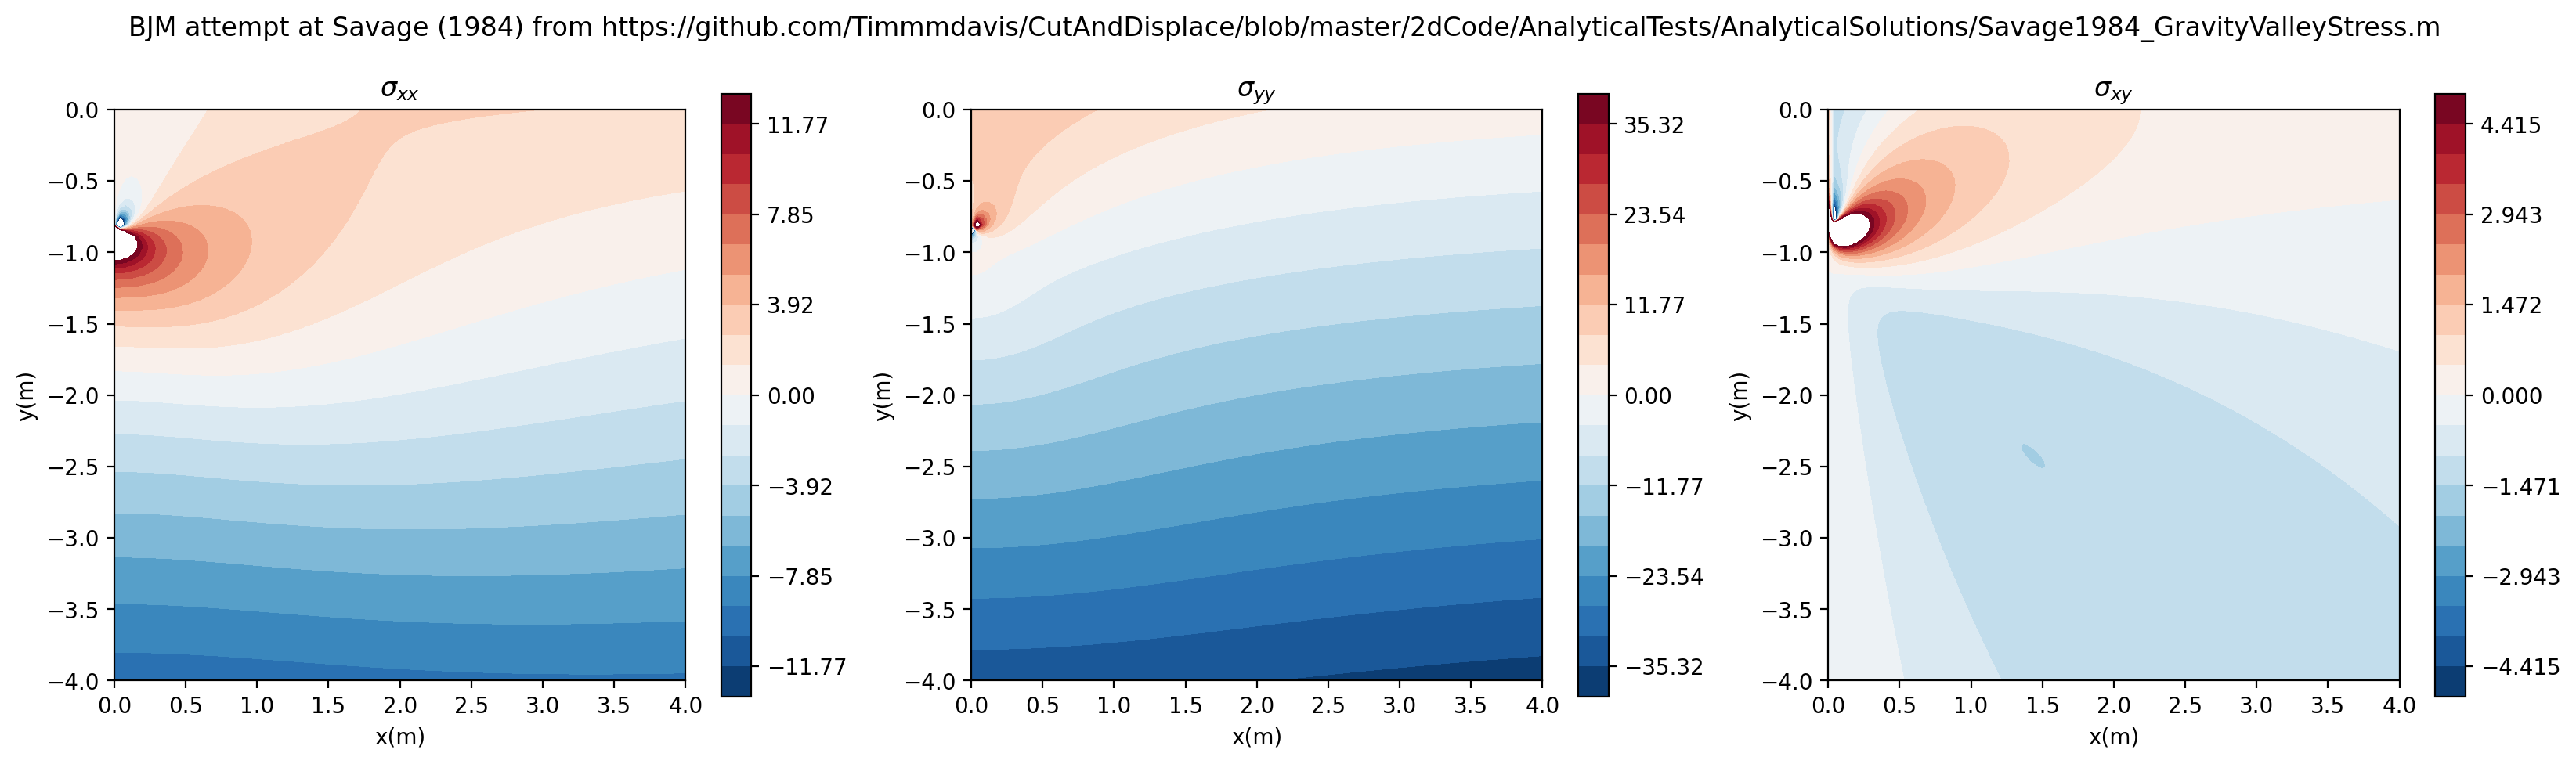

In [28]:
plt.figure(figsize=(20, 5))

maxval = rg * np.max(np.abs(y))
plt.subplot(1, 3, 1)
levels = np.linspace(-maxval * nu / (1 - nu), maxval * nu / (1 - nu), 21)
plt.title("$\sigma_{xx}$")
plt.contourf(
    x.reshape(n_obs, n_obs),
    y.reshape(n_obs, n_obs),
    (Sxx.reshape(n_obs, n_obs)),
    levels=levels,
    cmap="RdBu_r",
)
plt.colorbar()
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.gca().set_aspect("equal")

levels = np.linspace(-maxval, maxval, 21)
plt.subplot(1, 3, 2)
plt.title("$\sigma_{yy}$")
plt.contourf(
    x.reshape(n_obs, n_obs),
    y.reshape(n_obs, n_obs),
    Syy.reshape(n_obs, n_obs),
    levels=levels,
    cmap="RdBu_r",
)
plt.colorbar()
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.gca().set_aspect("equal")

levels = np.linspace(-maxval / 8, maxval / 8, 21)
plt.subplot(1, 3, 3)
plt.title("$\sigma_{xy}$")
plt.contourf(
    x.reshape(n_obs, n_obs),
    y.reshape(n_obs, n_obs),
    Sxy.reshape(n_obs, n_obs),
    levels=levels,
    cmap="RdBu_r",
)
plt.colorbar()
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.gca().set_aspect("equal")

plt.suptitle(
    "BJM attempt at Savage (1984) from https://github.com/Timmmdavis/CutAndDisplace/blob/master/2dCode/AnalyticalTests/AnalyticalSolutions/Savage1984_GravityValleyStress.m "
)

plt.show()